 Copyright (c) 2015-2020, Swiss Federal Institute of Technology (ETH Zurich)

 All rights reserved.
 
 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:
 
 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.
 
 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.
 
 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.
 
 THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
 AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
 IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
 DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
 FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
 DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
 SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
 CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
 OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
 OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
 

In [1]:
%pylab inline
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["legend.loc"] = "lower right"

Populating the interactive namespace from numpy and matplotlib


Set the path to the key file and change working-directory to the root directory of the dataprocessing framework

In [2]:
import os
base_dir = '/local/scratch/toolkit/'
os.environ['EXOT_ACCESS_DIR'] = str(base_dir + "benchmark_platforms_access/")
os.chdir(base_dir + 'datapro')
print("Working directory: " + str(os.getcwd()))
print("Key directory set to: " + str(os.environ['EXOT_ACCESS_DIR']))

Working directory: /local/scratch/toolkit/datapro
Key directory set to: /local/scratch/toolkit/benchmark_platforms_access/


# Imports

In [3]:
import toml    as TOML              # TOML library to handle config files
import pandas  as pd                # Pandas for data manipulation
import seaborn as sb                # Statistical data visualisation
import pathlib as PATH              # Used to convert strings to path objects for (de-)serialisation
import types   as tp                # Library used for online method development

#from copy   import copy, deepcopy   # TODO
#from pprint import pprint           # TODO

# scikit-learn packets
import sklearn.base                 #
import sklearn.svm                  # LinearSVC, SVC
import sklearn.pipeline             # make_pipeline
import sklearn.preprocessing        # StandardScaler
import sklearn.decomposition        # PCA
import sklearn.naive_bayes          # GaussianNB
import sklearn.metrics              # CM

# ExOT packets
import exot                       # Dataprocessing
import exot.experiment            # Experiment for execution
import exot.util                  # General utilities
import exot.layer                 # Data manipulation layers
from exot.util       import *
from exot.layer      import *
from exot.channel    import *
from exot.experiment import *

from exot.util.attributedict import AttributeDict

Tensorflow not available - excluding packets using it!


# Generate Experiment
#### 1. Load config

In [4]:
config = TOML.load("./configurations/examples/demo_exploratory_experiment.toml")
print(TOML.dumps(config))

name = "demo_exploratory_experiment"
save_path = "./data"
backup_path = "./data/_backup"
experiment_exists_action = "update"

[EXPERIMENT]
type = "ExploratoryExperiment"
channel = "ThermalCC"

[EXPERIMENT.PHASES]

[EXPERIMENT.GENERAL]
latency = 10
fan = true
governors = "userspace"
frequencies = "max"
sampling_period = 0.001
delay_after_spawn = 150.0
delay_after_auxiliary = 1.0
active_wait = false

[EXPERIMENT.LAYERS.io]
name = "TimeValue"

[EXPERIMENT.GENERAL.ARMv8]
delay_after_spawn = 120.0
sampling_period = 0.005

[EXPERIMENT.GENERAL.ARMv7]
delay_after_spawn = 120.0
sampling_period = 0.005

[EXPERIMENT.LAYERS.io.params]
timebase = "ns"

[ENVIRONMENTS.Haswell.APPS.snk]
executable = "meter_thermal_msr"
zone = "host"

[ENVIRONMENTS.Haswell.APPS.src]
executable = "generator_utilisation_mt"
zone = "host"

[ENVIRONMENTS.Haswell.src.generator]
host_pinning = 0
should_pin_host = true
cores = [ 5,]
host_policy = "round_robin"
host_priority = 99
worker_priority = 98
worker_policy = "round_rob

#### 2a Instantiate an experiment

Experiment factory will take the type and channel from the config.

In [5]:
channel    = ChannelFactory()(config["EXPERIMENT"]["channel"])
experiment = ExperimentFactory()(config["EXPERIMENT"]["type"], config=config, channel=channel)

2020-05-22 12:50:56 :: bootstrapped layer 'io' with TimeValue


#### 2b Define the phase traces (rdpstreams)
For the exploratory experiments, the user can freely design his own traces, in the form of rdpstreams. Those streams are added to the experiment config and used to instantiate the runs.
The rdpstreams will be deleted from the config during the generation process, to make sure that the serialised experiment does not get too big.

In [6]:
rdp_signals = [
                  pd.DataFrame(
                      # 10 periods of a rectangular waveform with 1Hz
                      data=np.hstack([np.full([20,1], 0.50), np.resize([1,0],[20,1])]), 
                      columns=['timestamp', 't440p']
                  ),
                  pd.DataFrame(
                      # 10 periods of a rectangular waveform with 2Hz
                      data=np.hstack([np.full([20,1], 0.25), np.resize([1,0],[20,1])]), 
                      columns=['timestamp', 't440p']
                  )
              ]
experiment.config.EXPERIMENT.PHASES = AttributeDict.from_dict(
    {'test':{'rdpstreams':rdp_signals,'repetitions':2}}
)

#### 2a Generate the experiment

In [7]:
experiment.generate()
experiment.print_duration()

2020-05-22 12:50:57 :: Estimated duration of a single repetition of the test phase is 0:05:17
2020-05-22 12:50:57 :: This results in a total estimated duration of 0:10:34 for all repetitions.


#### 3a. Eyeballing

You can access the streams via specific properties.

In [8]:
phase = "test"
rdpstream_id = 0
run = experiment.phases[phase][rdpstream_id]

# Access output streams
run.o_streams #-> mapping

{'rdpstream':     timestamp  t440p
 0         0.5    1.0
 1         0.5    0.0
 2         0.5    1.0
 3         0.5    0.0
 4         0.5    1.0
 5         0.5    0.0
 6         0.5    1.0
 7         0.5    0.0
 8         0.5    1.0
 9         0.5    0.0
 10        0.5    1.0
 11        0.5    0.0
 12        0.5    1.0
 13        0.5    0.0
 14        0.5    1.0
 15        0.5    0.0
 16        0.5    1.0
 17        0.5    0.0
 18        0.5    1.0
 19        0.5    0.0, 'rawstream':     timestamp  t440p
 0   500000000    1.0
 1   500000000    0.0
 2   500000000    1.0
 3   500000000    0.0
 4   500000000    1.0
 5   500000000    0.0
 6   500000000    1.0
 7   500000000    0.0
 8   500000000    1.0
 9   500000000    0.0
 10  500000000    1.0
 11  500000000    0.0
 12  500000000    1.0
 13  500000000    0.0
 14  500000000    1.0
 15  500000000    0.0
 16  500000000    1.0
 17  500000000    0.0
 18  500000000    1.0
 19  500000000    0.0}

#### 4. Write

Writes to disk, serialises the experiment, runs, and all streams.

In [9]:
experiment.write()

## Execute

Running `execute` will execute in all environments present in the configuration.

In [10]:
print("Available environments are: " + str(experiment.available_environments))
experiment.execute_in_environment("Haswell", phases=['test'])

2020-05-22 12:50:58 :: executing phases: ['test'] in env 'Haswell'


Available environments are: ['Haswell', 'Sandy', 'ARMv7', 'ARMv8']


2020-05-22 12:51:00 :: Haswell->host: connected: SSHUnixDriver
2020-05-22 12:51:00 :: Haswell->host: sending experiment
2020-05-22 12:51:00 :: Haswell->host: experiment sent!
2020-05-22 12:51:00 :: Haswell->host: configuring to {'latency': 10, 'fan': True, 'governors': 'userspace', 'frequencies': 'max', 'sampling_period': 0.001, 'delay_after_spawn': 150.0, 'delay_after_auxiliary': 1.0, 'active_wait': False, 'ARMv8': {'delay_after_spawn': 120.0, 'sampling_period': 0.005}, 'ARMv7': {'delay_after_spawn': 120.0, 'sampling_period': 0.005}, 'STANDARD': {'latency': 10, 'fan': True, 'governors': 'userspace', 'frequencies': 'max', 'sampling_period': 0.001, 'delay_after_spawn': 150.0, 'delay_after_auxiliary': 1.0, 'active_wait': False}}
2020-05-22 12:51:08 :: executing in env: 'Haswell', resume: False, reps: [0, 1], run: <Run at 0x7fd532d0fb38 (digested, config={'phase': 'test', 'rdpstream_id': 0, 'repetitions': 2})>
2020-05-22 12:51:08 :: executing in env: Haswell, rep: 0, estimated duration: 1

## Analyse

#### 1. Eyeballing single runs to check if experiment went well
##### 1a. Choose a run

In [11]:
phase = "test"
rdpstream_id = 0
run = experiment.phases[phase][rdpstream_id]; run

<Run at 0x7fd532d0fb38 (digested, config={'phase': 'test', 'rdpstream_id': 0, 'repetitions': 2})>

##### 1a. Get available environments

In [12]:
run.parent.layers.io.get_available_environments()

['Haswell']

##### 1b. Get raw measurements

- The `get_measurements` function requires the I/O layer to have at least the environment, and the repetition number configured.
- `describe_measurements` will tell you what columns are available, with more detail.

In [14]:
run.parent.layers.io.config.update(env="Haswell", rep=0)
measurements = run.parent.layers.io.get_measurements()
print(run.parent.layers.io.describe_measurements(measurements))

[{'module': 'meter', 'value': 'timestamp', 'dimension': '', 'unit': 'ns', 'quantity': '', 'method': ''}, {'module': 'thermal_msr', 'value': 'core', 'dimension': '0', 'unit': '°C', 'quantity': 'thermal', 'method': 'msr'}, {'module': 'thermal_msr', 'value': 'core', 'dimension': '2', 'unit': '°C', 'quantity': 'thermal', 'method': 'msr'}, {'module': 'thermal_msr', 'value': 'core', 'dimension': '4', 'unit': '°C', 'quantity': 'thermal', 'method': 'msr'}, {'module': 'thermal_msr', 'value': 'core', 'dimension': '6', 'unit': '°C', 'quantity': 'thermal', 'method': 'msr'}]


The raw measurements are packed into a pandas DataFrame and can be used for eyeballing the data.

##### 1.c Ingest the run

To ingest the run, and pipe the measurements through the layers, you need to provide the necessary runtime configuration. Most of it is passed by default, with the notable exception of the *Matcher*.

The *Matcher* defines which columns will be taken from the raw measurements, how they will be combined and passed on to the layers. For the thermal channel, you could use:

```python
env = "Haswell"
rep = 0
core = 4
matcher = [(wrangle.Matcher("thermal", "msr", ["core"], [core]), "sum")]
ingest_args = dict(io={"env": env, "rep": rep, "matcher": matcher})
```
Alternatives for the combination of multiple columns are `None` for no combination, "max", "min" and "avg".
You can also provide other parameters, e.g. the *decision device*. For eval runs, you'd have to get it from a train run, via `run.parent.layers.lne.decision_device` property.

In [15]:
ingest_args = dict(
  io={
      "env": 'Haswell', 
      "rep": 0, 
      "matcher": [(exot.util.wrangle.Matcher("thermal", "msr", ["core"], [2]), None)]
  }
)
run.ingest(**ingest_args)

After running ingest, the run's input streams will be populated, and can be accessed via:

- `run.i_lnestream`
- `run.i_rdpstream`
- `run.i_rawstream`

##### 1d. Plot rdp measurements

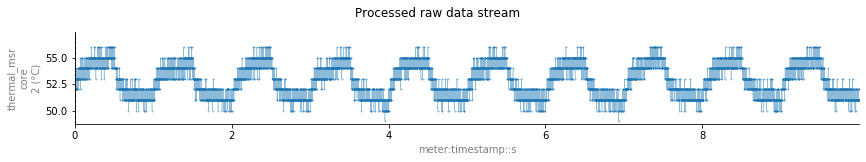

In [22]:
from exot.plotting.run_plotter import *

with RunPlotter(run, save_pdf=False) as plotter:
    plotter.plot_rdpstream(start=0,end=10)